In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.initializers import *
from keras.models import load_model
from keras.losses import *
import scipy.io.wavfile as sciwav
import multiprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from nn_experimental import *
from perceptual_loss import *
from evaluation import *

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
# softmax hardness variable
tau = K.variable(0.0001, name = "hardness")

In [8]:
DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR
    
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 15
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = channel_change_block(1, FILT_SIZE)(enc)
    
    # quantization
    enc = Reshape((CHANNEL_SIZE,))(enc)
    pre_quant = Model(inputs = enc_input, outputs = enc)
    #enc = DeltaQuantization()(enc)
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE, NBINS))
    dec = dec_input
    
    # dequantization
    #dec = DeltaDequantization()(dec)  
    dec = SoftmaxDequantization()(dec) 
    post_dequant = Model(inputs = dec_input, outputs = dec)
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(1, FILT_SIZE)(dec)

    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec, pre_quant, post_dequant

In [9]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    loss = tau * entropy
    return K.switch(QUANTIZATION_ON, loss, K.zeros_like(loss))

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    #return sparsity
    return K.switch(QUANTIZATION_ON, sparsity, K.zeros_like(sparsity))

In [10]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'ChannelResize1D' : ChannelResize1D,
                  'LinearUpSampling1D' : LinearUpSampling1D,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'DeltaQuantization' : DeltaQuantization,
                  'DeltaDequantization' : DeltaDequantization,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'DFT_REAL' : DFT_REAL,
                  'DFT_IMAG' : DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'keras_dft_mag' : keras_dft_mag,
                  'keras_dct' : keras_dct,
                  'perceptual_transform' : perceptual_transform,
                  'perceptual_distance' : perceptual_distance}

In [11]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder, pre_quant, post_dequant = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

In [12]:
# model parameters
loss_weights = [30.0, 1.0, 5.0, 1.0]
loss_functions = [rmse, perceptual_distance, code_sparsity, code_entropy]
n_recons = 2
n_code = 2
n_error = 0
assert(n_recons + n_code + n_error == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [13]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_pre_quant = pre_quant(model_input)
model_reconstructed = decoder(model_embedding)
model_post_dequant = post_dequant(model_embedding)
rmse_lambda = Lambda(lambda x : rmse(x[0], x[1]),
                     output_shape = lambda s : s[0])
model_quant_error = rmse_lambda([model_pre_quant, model_post_dequant])

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code + \
                                            [model_quant_error] * n_error)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_4_1/add_12/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_4_1/add_12/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 31) dtype=float32>, <tf.Tensor 'model_2_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 31) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [14]:
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam(clipvalue = 1.0))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_2 (Model)              (None, 256, 31)           139891.0  
_________________________________________________________________
model_4 (Model)              (None, 512, 1)            201427    
Total params: 341,318
Trainable params: 341,318
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         16939.2
Avg err:     60.0091
PESQ:        1.90365338326


[16939.174, 60.009098, 1.9036533832550049]

In [16]:
# saves current model
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    #os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    #np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('./' + prefix + '_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [17]:
def evaluate_training(autoencoder, lead = ""):
    def set_evaluation(windows, wparams, eval_idxs):
        before_after_pairs = np.array([run_model_on_windows(windows[i],
                                                    wparams[i],
                                                    autoencoder,
                                                    argmax = True)
                                       for i in eval_idxs])
        
        NUM_THREADS = 8
        list_range = np.arange(0, len(eval_idxs))
        slices = [list_range[i:None:NUM_THREADS]
                  for i in xrange(0, NUM_THREADS)]
        
        def thread_func(pairs, q):
            for p in pairs:
                q.put(evaluation_metrics(p[0], p[1]))
                
        q = multiprocessing.Queue()
        threads = [multiprocessing.Process(target = thread_func,
                                           args = (before_after_pairs[slices[i]], q))
                   for i in xrange(0, NUM_THREADS)]
        [t.start() for t in threads]
        [t.join() for t in threads]
        
        return np.array([q.get() for i in list_range])
    
    train_eval_idxs = random.sample(range(0, len(train_windows)), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows)), VAL_EVALUATE)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    
    # train set evaluation
    train_metrics = set_evaluation(train_windows, train_wparams,
                                   train_eval_idxs)
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    
    # validation set evaluation
    val_metrics = set_evaluation(val_windows, val_wparams,
                                 val_eval_idxs)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [18]:
X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_EPOCHS = 400
EPOCHS_BEFORE_QUANT_ON = 10
EPOCHS_BEFORE_TAU = 30

ORIG_BITRATE = 256.00
TARGET_BITRATE = 16.00
PRE_ENTROPY_RATE = ORIG_BITRATE / DOWNSAMPLE_FACTOR

TARGET_ENTROPY = (TARGET_BITRATE / PRE_ENTROPY_RATE * 16.0)
TARGET_ENTROPY *= (STEP_SIZE / float(WINDOW_SIZE))
TARGET_ENTROPY_FUZZ = 0.1

TAU_CHANGE_RATE = 0.0125
MIN_TAU = 0.0125

NUM_QUANT_VECS = 5000

STARTING_LR = 0.001
ENDING_LR = 0.00025

print "Target entropy:", TARGET_ENTROPY

Target entropy: 1.875


In [19]:
best_val_pesq = 0.0
K.set_value(tau, 0.0)
T_i = 0.0

In [35]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})
lead = "    "

for epoch in range(17, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    num_batches = len(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        # cosine annealing for model's learning rate
        train_pct = T_i / float(NUM_EPOCHS)
        opt_lr = ENDING_LR + 0.5 * (STARTING_LR - ENDING_LR) * (1 + math.cos(3.14159 * train_pct))
        T_i += (1.0 / num_batches)
        K.set_value(model.optimizer.lr, opt_lr)
        
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
               
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, 1, 1))] * n_code + \
              [np.zeros((nbatch, 1))] * n_error

        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau), opt_lr,
        
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 500
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy

        # ---------------------------------------------------------
        # handle updating entropy weight (tau)
        # ---------------------------------------------------------
        if (epoch >= EPOCHS_BEFORE_TAU):
            old_tau = K.get_value(tau)

            if (entropy < TARGET_ENTROPY - TARGET_ENTROPY_FUZZ):
                new_tau = old_tau - TAU_CHANGE_RATE
                if (new_tau <= MIN_TAU):
                    new_tau = MIN_TAU

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            elif (entropy > TARGET_ENTROPY + TARGET_ENTROPY_FUZZ):
                new_tau = old_tau + TAU_CHANGE_RATE

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            else:
                print lead + "Tau stays at", old_tau
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq and entropy <= TARGET_ENTROPY):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq

            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
            patience_epoch = epoch
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (epoch == EPOCHS_BEFORE_QUANT_ON):
        print lead + "----------------"
        print lead + "Turning quantization on!"
        
        random_windows = []
        for i in xrange(0, NUM_QUANT_VECS):
            w_idx = random.randint(0, train_processed.shape[0] - 1)
            random_windows.append(train_processed[w_idx])

        random_windows = np.array(random_windows)
        print lead + "    Selecting random code vectors for analysis..."
        encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
        encoded_windows = encoded_windows[:, :, 0]

        diffs = np.roll(encoded_windows, -1, axis = 1) - encoded_windows
        diffs = diffs[:, :-1]
        diffs = np.reshape(diffs, (-1, 1))

        print lead + "    K means clustering for bins initialization..."
        km = MiniBatchKMeans(n_clusters = NBINS).fit(diffs)
        K.set_value(QUANT_BINS, km.cluster_centers_.flatten())

        K.set_value(QUANTIZATION_ON, True)
        
        cluster_score = np.sqrt(np.median(np.min(km.transform(diffs), axis = 1)))
        print lead + "    Done. Cluster score:", cluster_score

Epoch 17:
    101120:  [1.029251 0.008257 0.601268 0.036052 0.000000] [1.029251 0.247725 0.601268 0.180258 0.000000] 0.0 0.000996652046221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    Total time for epoch: 31.4858958721s
    ----------------
    Code entropy: 3.83234400992
    ----------------
    Evaluating autoencoder...
    SA1:  

KeyboardInterrupt: 

In [21]:
if False:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]

In [22]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [23]:
#for i in xrange(0, len(enc)):
#    print i, enc[i]

In [24]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         2202.42
Avg err:     26.708
PESQ:        3.64580225945
MSE:         2245.29
Avg err:     27.1766
PESQ:        3.58276867867
MSE:         2337.41
Avg err:     20.6977
PESQ:        3.77993249893
MSE:         2354.29
Avg err:     20.9983
PESQ:        3.73111391068
MSE:         1.28261e+06
Avg err:     705.215
PESQ:        2.99862575531
MSE:         1.28585e+06
Avg err:     706.962
PESQ:        2.99907445908


[1285851.8, 706.96155, 2.9990744590759277]

In [25]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9472/10000 [===========================>..] - ETA: 0s

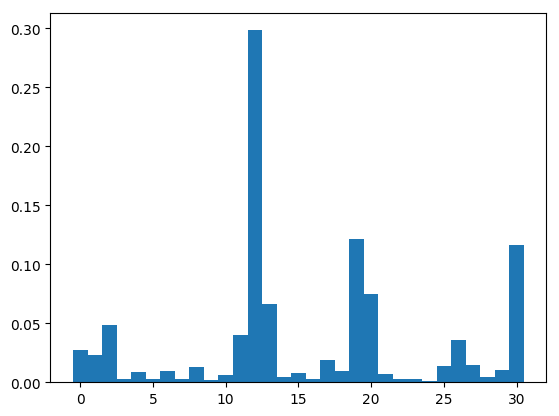

Entropy of distribution: 3.63596319559
[0.027675 0.022898 0.048194 0.002640 0.009088 0.002816 0.009297 0.002707
 0.012848 0.001891 0.006453 0.040183 0.298422 0.066036 0.004574 0.007942
 0.002982 0.019247 0.009399 0.121400 0.074638 0.006679 0.002523 0.002364
 0.001019 0.013837 0.036253 0.014909 0.004327 0.010704 0.116055]
Bins:
[0.478718 -0.347082 0.300924 -0.795226 1.045054 -0.737222 -0.499127
 -0.870241 0.729404 -1.333599 1.461616 -0.253188 0.030959 -0.156165
 1.909263 1.219338 -0.683651 0.566330 0.920807 0.123414 0.211202 -0.569501
 -0.973705 -1.108244 -1.742753 -0.425671 0.383790 0.645415 -0.638009
 0.825219 -0.064386]


In [26]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print hist
print "Bins:"
print K.eval(QUANT_BINS)

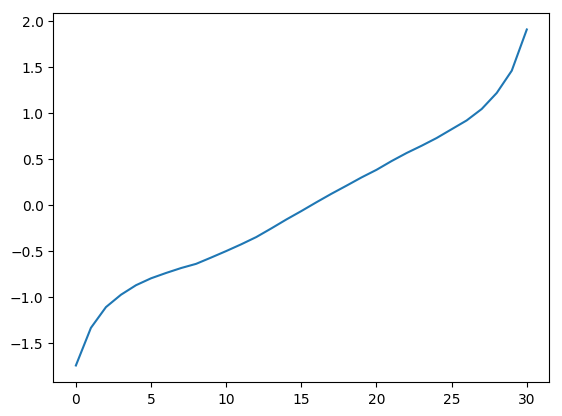

In [27]:
plt.plot(np.sort(np.array(K.eval(QUANT_BINS)).flatten()))
plt.show()

In [28]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [29]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [30]:
before_quantization = pre_quant.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)
after_dequantization = post_dequant.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [31]:
K.eval(enc[-1].SOFTMAX_TEMP)

504.37521

In [32]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 0.999995 1.000000 0.996837 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 0.999995 0.999939
 0.999796 0.999729 1.000000 1.000000 1.000000 0.999943 0.999908 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 0.840935 0.903481 0.762528 0.999974 1.000000 0.987637 1.000000 1.000000
 0.982075 0.998471 0.995216 1.000000 1.000000 0.999630 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 0.917516 0.958624 0.992261 1.000000 1.000000 0.724977 0.999999 1.000000
 0.999984 0.999998 1.000000 1.000000 1.000000 1.000000 0.999438 0.999983
 1.000000 1.000000 1.000000 1.000000 1.000000 0.999982 0.876670 1.000000
 1.000000 0.999439 1.000000 1.000000 1.000000 1.000

In [33]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.985958
0.919015066964


Original


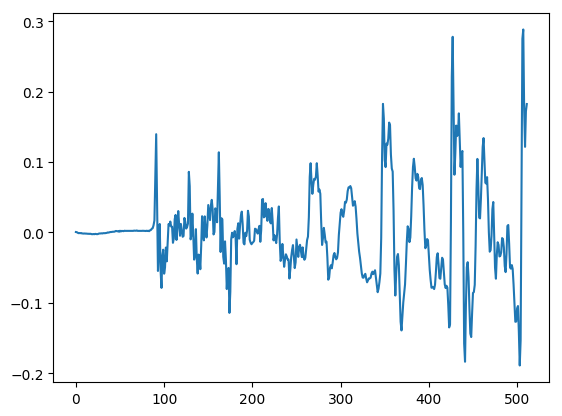

Reconstruction


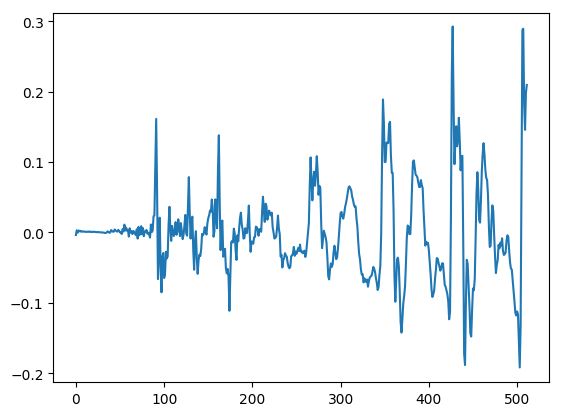

Before quantization


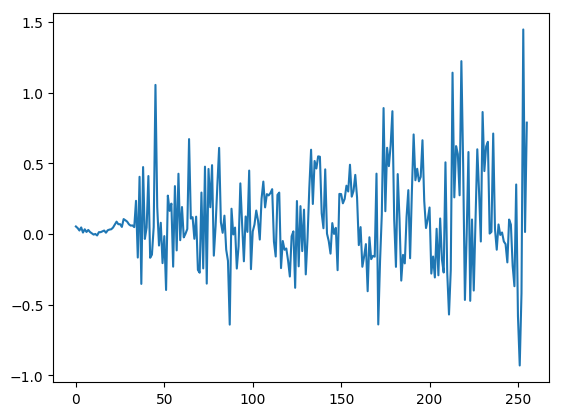

After dequantization


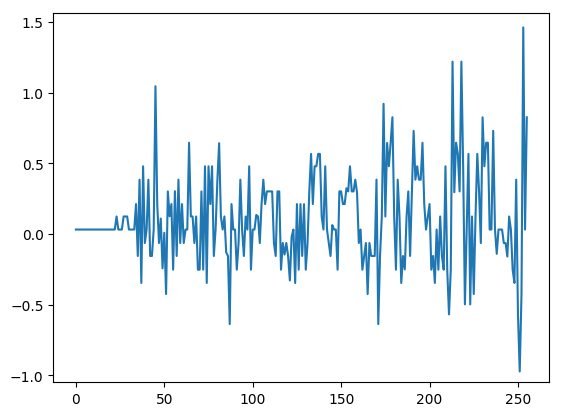

Error


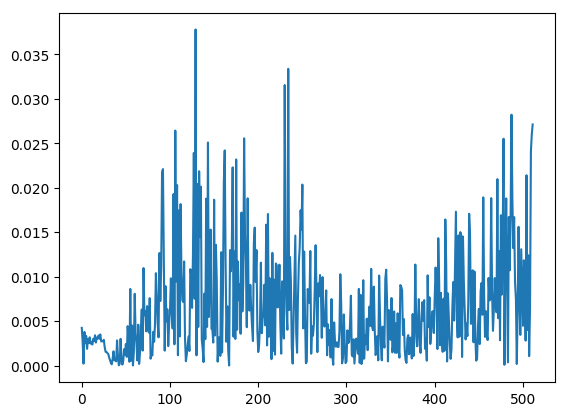

In [34]:
idx = 25
#idx=90

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Before quantization"
    plt.plot(before_quantization[idx])
    ylim = plt.gca().get_ylim()
    plt.show()

    print "After dequantization"
    plt.plot(after_dequantization[idx])
    plt.ylim(ylim)
    plt.show()

'''
print "Code (argmax)"
argmax_code_vec = embed[idx]
embed_sum = np.sum(embed[idx], axis = -1)
argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
argmax_code_vec = unquantize_vec(argmax_code_vec)
plt.plot(argmax_code_vec)
plt.show()

print "Code (non-argmax)"
na_code_vec = embed[idx]
na_code_vec = unquantize_vec(na_code_vec)
plt.plot(na_code_vec)
plt.show()

print "Difference between argmax and non-argmax"
plt.plot(abs(argmax_code_vec - na_code_vec))
plt.show()
'''
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()